<a href="https://colab.research.google.com/github/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis/blob/master/vgg_digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis.git
%cd AudioClassificationWithDeepLearningAnalysis
!pwd

Cloning into 'AudioClassificationWithDeepLearningAnalysis'...
remote: Enumerating objects: 366, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 366 (delta 110), reused 121 (delta 41), pack-reused 145
Receiving objects: 100% (366/366), 49.62 MiB | 13.17 MiB/s, done.
Resolving deltas: 100% (166/166), done.
Checking out files: 100% (66/66), done.
/content/AudioClassificationWithDeepLearningAnalysis
/content/AudioClassificationWithDeepLearningAnalysis


# Benchmark: training both old and novel tasks from scratch


In this section we will train both old and novel tasks simultaneously from scratch to set a benchmark. This benchmark will tell us how much higher accuracy we could get after training all data together. Also later we can compare other algorithms result such as LwF with this benchmark.

First, we have train VGG netwrok for both data and saved the trained model as "checkpoint_vgg_benchmark.pth". We have plot the training and validation accuracy and loss plots for all data. Later, we used "checkpoint_vgg_benchmark.pth" this saved model to calculate the accuracy of old and novel tasks seperately. We got following results:



```
-----------------------|------------------------
  Old Tasks Accuracy   |  Novel Task Accuracy   
-----------------------|------------------------
        0.85           |       0.71            
-----------------------|------------------------
```





In [2]:
import torch
import torch.nn as nn
import os
import copy
import torch.nn.functional as F
import torchaudio
import models
from torch.utils.data import DataLoader,random_split,Dataset
# from torch.optim import lr_scheduler
import torchvision
from utils import label_to_index, index_to_label, get_average_of_list
import utils
from dataset import SubsetSC
# import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
# from datetime import datetime

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [8, 8]

In [ ]:
torch.cuda.is_available()

True

# **Pre-dataprocessing and data loading**

In [ ]:
digits = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'] 
train_dataset = SubsetSC("training", "old")
test_dataset = SubsetSC("testing", "old")

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [ ]:
#for benchmark training and validation data should be 
# combinaition of digits as well as new command
novel_data = ["follow"]
novel_train_dataset = SubsetSC("training", "novel", novel_data)
novel_test_dataset = SubsetSC("testing", "novel", novel_data)
train_dataset._walker += novel_train_dataset._walker
test_dataset._walker += novel_test_dataset._walker
digits += novel_data

In [ ]:

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
        tensors, targets = [], []
        for waveform, label in batch:
                tensors += [torch.squeeze(waveform)]
                targets += [label_to_index(digits, label)]
                
        tensors = torch.unsqueeze(pad_sequence(tensors), 1)
        targets = torch.stack(targets)
        return tensors, targets


# old_traindata, old_testdata = torch.utils.data.random_split(old_data_set, [round(len(old_data_set)*.8), round(len(old_data_set)*.2)])
train_dataloader = DataLoader(train_dataset,batch_size=100, collate_fn=collate_fn, shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=100, collate_fn=collate_fn, shuffle=True)

# **Training for spoken digit recognizer from scratch**

In [ ]:
#log dict to save all records
log = []

In [ ]:

print("Initializing the neural network...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
model = models.VGGNet()

#in case of benchmark need to add extra node at last linear layer in vgg
in_features = model.linear.in_features
out_features = model.linear.out_features
out_features += len(novel_data)
model.linear = nn.Linear(in_features=in_features, out_features=out_features)


model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,80,120,150, 200, 250, 280], gamma=0.5)
# Training loop
num_epoch = 301
best_accuracy = 0.0
print("Started training !")
for epoch in tqdm(range(num_epoch), total=num_epoch, leave=False):
  running_loss = []
  train_accuracy = []

  for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False, desc=f'Epoch: {epoch}/{num_epoch}'): 
    model.train()
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    logits = model(inputs) #batch_size x 14
    loss = F.cross_entropy(logits, labels)
    loss.backward() 
    optimizer.step()
    scheduler.step()
    running_loss.append(loss.item())
    _, pred = logits.max(1)
    acc = (pred == labels).sum().item() / pred.size(0) #pred size= [batch_size, no of classes] e.g(10,14)
    train_accuracy.append(acc)

  batch_train_loss = sum(running_loss)/len(running_loss)
  print(f'Epoch {epoch}/{num_epoch}... Loss: {batch_train_loss}')
  batch_train_accuracy = sum(train_accuracy)/len(train_accuracy)
  log.append({
      'mode': 'train',
      'epoch': epoch,
      'loss': batch_train_loss,
      'accuracy': batch_train_accuracy
      })

  # Evaluate the model on the test set every 10 epochs

  validation_loss = []
  validation_accuracy = []
  if epoch % 5 == 0:
    #validation loss and accuracy for novel classes
    with torch.no_grad():
      model.eval()
      for i, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader), leave=False, desc=f'Epoch: {epoch}/{num_epoch}'):
        inputs, labels = data[0].to(device), data[1].to(device)
        logits = model(inputs)
        loss = F.cross_entropy(logits,labels)
        validation_loss.append(loss.item())
        _, pred = logits.max(1)
        acc = (pred == labels).sum().item() / pred.size(0) #pred size= [batch_size, no of classes] e.g(10,14)
        validation_accuracy.append(acc)
      
      batch_validation_loss = sum(validation_loss)/len(validation_loss)
      print(f'Epoch {epoch}/{num_epoch}... Validation loss: {batch_validation_loss}')
      # writer.add_scalars('Loss', {'Test':batch_validation_loss}, epoch)
      # Saving model if accuracy on the test set is better than previous best model
      batch_val_accuracy = sum(validation_accuracy)/len(validation_accuracy)
      print(f'Epoch {epoch}/{num_epoch}... Accuracy: {batch_val_accuracy}')
      log.append({
      'mode': 'val',
      'epoch': epoch,
      'loss': batch_validation_loss,
      'accuracy': batch_val_accuracy
      })
      
      if batch_val_accuracy > best_accuracy:
          best_accuracy = batch_val_accuracy
          torch.save(model.state_dict(), 'checkpoint_vgg_benchmark.pth')
          torch.save(optimizer.state_dict(), 'optimizer_checkpoint_vgg_benchmark.pth')
          print(f'Best model saved at epoch {epoch}/{num_epoch}')

Initializing the neural network...
Device: cuda
Started training !


  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 0/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 0/301... Loss: 2.53059278594123


Epoch: 0/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 0/301... Validation loss: 2.354075271029805
Epoch 0/301... Accuracy: 0.1719517221077421
Best model saved at epoch 0/301


Epoch: 1/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 1/301... Loss: 2.358403001596898


Epoch: 2/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 2/301... Loss: 2.3508171022674182


Epoch: 3/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 3/301... Loss: 2.3400913668267522


Epoch: 4/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 4/301... Loss: 2.3227410434204856


Epoch: 5/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 5/301... Loss: 2.3043180383281943


Epoch: 5/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 5/301... Validation loss: 2.2867391553036
Epoch 5/301... Accuracy: 0.2137327053282308
Best model saved at epoch 5/301


Epoch: 6/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 6/301... Loss: 2.280061411563261


Epoch: 7/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 7/301... Loss: 2.2536101859292867


Epoch: 8/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 8/301... Loss: 2.2230578711003433


Epoch: 9/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 9/301... Loss: 2.197691551844279


Epoch: 10/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 10/301... Loss: 2.159487749029089


Epoch: 10/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 10/301... Validation loss: 2.1015043425005535
Epoch 10/301... Accuracy: 0.31311156903149834
Best model saved at epoch 10/301


Epoch: 11/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 11/301... Loss: 2.1319436026208196


Epoch: 12/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 12/301... Loss: 2.0957840931268388


Epoch: 13/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 13/301... Loss: 2.061846821690783


Epoch: 14/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 14/301... Loss: 2.027840203120385


Epoch: 15/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 15/301... Loss: 1.9891752990675562


Epoch: 15/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 15/301... Validation loss: 1.864931583404541
Epoch 15/301... Accuracy: 0.39556078893141017
Best model saved at epoch 15/301


Epoch: 16/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 16/301... Loss: 1.9542392050778423


Epoch: 17/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 17/301... Loss: 1.917143608905651


Epoch: 18/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 18/301... Loss: 1.885026721601133


Epoch: 19/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 19/301... Loss: 1.8534498709219474


Epoch: 20/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 20/301... Loss: 1.819724894747322


Epoch: 20/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 20/301... Validation loss: 1.6363049967344416
Epoch 20/301... Accuracy: 0.482923167500736
Best model saved at epoch 20/301


Epoch: 21/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 21/301... Loss: 1.7933084423159376


Epoch: 22/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 22/301... Loss: 1.76497063577911


Epoch: 23/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 23/301... Loss: 1.7410782763987411


Epoch: 24/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 24/301... Loss: 1.712944425182578


Epoch: 25/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 25/301... Loss: 1.6871163215166256


Epoch: 25/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 25/301... Validation loss: 1.4647423638853916
Epoch 25/301... Accuracy: 0.5358051221666178
Best model saved at epoch 25/301


Epoch: 26/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 26/301... Loss: 1.661490696742211


Epoch: 27/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 27/301... Loss: 1.6409331227526254


Epoch: 28/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 28/301... Loss: 1.6218014340341826


Epoch: 29/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 29/301... Loss: 1.5947770630871807


Epoch: 30/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 30/301... Loss: 1.5704764510378426


Epoch: 30/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 30/301... Validation loss: 1.3219006948692853
Epoch 30/301... Accuracy: 0.5827818663526639
Best model saved at epoch 30/301


Epoch: 31/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 31/301... Loss: 1.556631992481373


Epoch: 32/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 32/301... Loss: 1.5254877384798027


Epoch: 33/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 33/301... Loss: 1.5120821487756424


Epoch: 34/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 34/301... Loss: 1.495924366550681


Epoch: 35/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 35/301... Loss: 1.4736649289543247


Epoch: 35/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 35/301... Validation loss: 1.2020570372426234
Epoch 35/301... Accuracy: 0.6327200471003828
Best model saved at epoch 35/301


Epoch: 36/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 36/301... Loss: 1.4535713890452444


Epoch: 37/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 37/301... Loss: 1.4411520807831375


Epoch: 38/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 38/301... Loss: 1.4154271364212037


Epoch: 39/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 39/301... Loss: 1.3992915780455977


Epoch: 40/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 40/301... Loss: 1.3844888675360032


Epoch: 40/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 40/301... Validation loss: 1.0889918873476427
Epoch 40/301... Accuracy: 0.6661760376803064
Best model saved at epoch 40/301


Epoch: 41/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 41/301... Loss: 1.3703225247653914


Epoch: 42/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 42/301... Loss: 1.3540238350997735


Epoch: 43/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 43/301... Loss: 1.3361625989278159


Epoch: 44/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 44/301... Loss: 1.3209774018805704


Epoch: 45/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 45/301... Loss: 1.3006671593513017


Epoch: 45/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 45/301... Validation loss: 0.995065147100493
Epoch 45/301... Accuracy: 0.6956785398881363
Best model saved at epoch 45/301


Epoch: 46/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 46/301... Loss: 1.2913327958848742


Epoch: 47/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 47/301... Loss: 1.2780949789800762


Epoch: 48/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 48/301... Loss: 1.262164197439029


Epoch: 49/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 49/301... Loss: 1.2537783827310727


Epoch: 50/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 50/301... Loss: 1.2325534760216137


Epoch: 50/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 50/301... Validation loss: 0.9165282138558322
Epoch 50/301... Accuracy: 0.7172593464821903
Best model saved at epoch 50/301


Epoch: 51/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 51/301... Loss: 1.2207972547154369


Epoch: 52/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 52/301... Loss: 1.2192124743520478


Epoch: 53/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 53/301... Loss: 1.1995119739461828


Epoch: 54/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 54/301... Loss: 1.1812734238895368


Epoch: 55/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 55/301... Loss: 1.1740271151801687


Epoch: 55/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 55/301... Validation loss: 0.8466590379559716
Epoch 55/301... Accuracy: 0.742778922578746
Best model saved at epoch 55/301


Epoch: 56/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 56/301... Loss: 1.160241887010174


Epoch: 57/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 57/301... Loss: 1.1525723527978968


Epoch: 58/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 58/301... Loss: 1.1439528734595688


Epoch: 59/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 59/301... Loss: 1.1429283140618125


Epoch: 60/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 60/301... Loss: 1.1225420554478964


Epoch: 60/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 60/301... Validation loss: 0.7943386005800824
Epoch 60/301... Accuracy: 0.7610568148366206
Best model saved at epoch 60/301


Epoch: 61/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 61/301... Loss: 1.1161303453975253


Epoch: 62/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 62/301... Loss: 1.1104740977287293


Epoch: 63/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 63/301... Loss: 1.0956757009765248


Epoch: 64/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 64/301... Loss: 1.0838384847582123


Epoch: 65/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 65/301... Loss: 1.0789944954860358


Epoch: 65/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 65/301... Validation loss: 0.7444012594777484
Epoch 65/301... Accuracy: 0.7769031498380925
Best model saved at epoch 65/301


Epoch: 66/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 66/301... Loss: 1.0771372430118513


Epoch: 67/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 67/301... Loss: 1.0590130418906978


Epoch: 68/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 68/301... Loss: 1.0473138111609


Epoch: 69/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 69/301... Loss: 1.0475454576221512


Epoch: 70/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 70/301... Loss: 1.041849489270905


Epoch: 70/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 70/301... Validation loss: 0.7066698531771816
Epoch 70/301... Accuracy: 0.7880659405357666
Best model saved at epoch 70/301


Epoch: 71/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 71/301... Loss: 1.0288771307026898


Epoch: 72/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 72/301... Loss: 1.0151987100824897


Epoch: 73/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 73/301... Loss: 1.0236317521260108


Epoch: 74/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 74/301... Loss: 1.0146157526675565


Epoch: 75/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 75/301... Loss: 0.9980667005350561


Epoch: 75/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 75/301... Validation loss: 0.6658567453539649
Epoch 75/301... Accuracy: 0.7977539005004415
Best model saved at epoch 75/301


Epoch: 76/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 76/301... Loss: 0.996763230105977


Epoch: 77/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 77/301... Loss: 0.9917999191048704


Epoch: 78/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 78/301... Loss: 0.979314617610272


Epoch: 79/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 79/301... Loss: 0.9732250952426298


Epoch: 80/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 80/301... Loss: 0.9636924206474681


Epoch: 80/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 80/301... Validation loss: 0.6359281775563262
Epoch 80/301... Accuracy: 0.8087165145716808
Best model saved at epoch 80/301


Epoch: 81/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 81/301... Loss: 0.9601726221449581


Epoch: 82/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 82/301... Loss: 0.9482176336241357


Epoch: 83/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 83/301... Loss: 0.9444855060106442


Epoch: 84/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 84/301... Loss: 0.9411263290746712


Epoch: 85/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 85/301... Loss: 0.9391491385153782


Epoch: 85/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 85/301... Validation loss: 0.6056202213431514
Epoch 85/301... Accuracy: 0.8168089490727115
Best model saved at epoch 85/301


Epoch: 86/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 86/301... Loss: 0.9244415746794806


Epoch: 87/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 87/301... Loss: 0.9268001501942859


Epoch: 88/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 88/301... Loss: 0.9115759662639947


Epoch: 89/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 89/301... Loss: 0.9135914016652991


Epoch: 90/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 90/301... Loss: 0.9092057525375743


Epoch: 90/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 90/301... Validation loss: 0.5789345177107079
Epoch 90/301... Accuracy: 0.8226229025610835
Best model saved at epoch 90/301


Epoch: 91/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 91/301... Loss: 0.9037851104029903


Epoch: 92/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 92/301... Loss: 0.8955670776190581


Epoch: 93/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 93/301... Loss: 0.8932217631810977


Epoch: 94/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 94/301... Loss: 0.8852314984356916


Epoch: 95/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 95/301... Loss: 0.88437123372231


Epoch: 95/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 95/301... Validation loss: 0.5619221454442933
Epoch 95/301... Accuracy: 0.827583161613188
Best model saved at epoch 95/301


Epoch: 96/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 96/301... Loss: 0.8828854244432331


Epoch: 97/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 97/301... Loss: 0.8745451778541377


Epoch: 98/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 98/301... Loss: 0.8712428721380823


Epoch: 99/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 99/301... Loss: 0.8659386823206772


Epoch: 100/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 100/301... Loss: 0.8633105604736894


Epoch: 100/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 100/301... Validation loss: 0.5368450374104256
Epoch 100/301... Accuracy: 0.8332263762143067
Best model saved at epoch 100/301


Epoch: 101/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 101/301... Loss: 0.8527213265866409


Epoch: 102/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 102/301... Loss: 0.8538504363578043


Epoch: 103/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 103/301... Loss: 0.8441653472405893


Epoch: 104/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 104/301... Loss: 0.8442380579901331


Epoch: 105/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 105/301... Loss: 0.8340913604806971


Epoch: 105/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 105/301... Validation loss: 0.5161582806775736
Epoch 105/301... Accuracy: 0.8380953782749484
Best model saved at epoch 105/301


Epoch: 106/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 106/301... Loss: 0.8340391620441719


Epoch: 107/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 107/301... Loss: 0.8363315928129502


Epoch: 108/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 108/301... Loss: 0.8256327595239804


Epoch: 109/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 109/301... Loss: 0.8256670890031037


Epoch: 110/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 110/301... Loss: 0.8277094252315569


Epoch: 110/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 110/301... Validation loss: 0.5016750131928643
Epoch 110/301... Accuracy: 0.8460788931410067
Best model saved at epoch 110/301


Epoch: 111/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 111/301... Loss: 0.8108314631161866


Epoch: 112/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 112/301... Loss: 0.8063005576899023


Epoch: 113/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 113/301... Loss: 0.8115612012368661


Epoch: 114/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 114/301... Loss: 0.8053993251588609


Epoch: 115/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 115/301... Loss: 0.7941998253633946


Epoch: 115/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 115/301... Validation loss: 0.4857847482659096
Epoch 115/301... Accuracy: 0.8481719163968205
Best model saved at epoch 115/301


Epoch: 116/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 116/301... Loss: 0.7959003854680944


Epoch: 117/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 117/301... Loss: 0.7933490672229249


Epoch: 118/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 118/301... Loss: 0.7912469313468462


Epoch: 119/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 119/301... Loss: 0.7920581857363383


Epoch: 120/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 120/301... Loss: 0.7809229136985025


Epoch: 120/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 120/301... Validation loss: 0.468564628168594
Epoch 120/301... Accuracy: 0.8540329702678835
Best model saved at epoch 120/301


Epoch: 121/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 121/301... Loss: 0.7726353747609221


Epoch: 122/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 122/301... Loss: 0.7762700269987554


Epoch: 123/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 123/301... Loss: 0.7716349360383588


Epoch: 124/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 124/301... Loss: 0.7713131290894968


Epoch: 125/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 125/301... Loss: 0.763146659621486


Epoch: 125/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 125/301... Validation loss: 0.45385548957558564
Epoch 125/301... Accuracy: 0.8587459523108624
Best model saved at epoch 125/301


Epoch: 126/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 126/301... Loss: 0.7647728949417303


Epoch: 127/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 127/301... Loss: 0.7577881215531149


Epoch: 128/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 128/301... Loss: 0.7567482903415774


Epoch: 129/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 129/301... Loss: 0.7592071400748359


Epoch: 130/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 130/301... Loss: 0.7510713151943537


Epoch: 130/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 130/301... Validation loss: 0.4412992374841557
Epoch 130/301... Accuracy: 0.8602973211657345
Best model saved at epoch 130/301


Epoch: 131/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 131/301... Loss: 0.753953289176211


Epoch: 132/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 132/301... Loss: 0.7449998252921635


Epoch: 133/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 133/301... Loss: 0.7356524401240878


Epoch: 134/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 134/301... Loss: 0.7369830131530761


Epoch: 135/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 135/301... Loss: 0.7378771912904434


Epoch: 135/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 135/301... Validation loss: 0.4293523617955141
Epoch 135/301... Accuracy: 0.863676773623786
Best model saved at epoch 135/301


Epoch: 136/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 136/301... Loss: 0.7361432677433815


Epoch: 137/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 137/301... Loss: 0.7356853384294627


Epoch: 138/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 138/301... Loss: 0.727569552851312


Epoch: 139/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 139/301... Loss: 0.7254175164081432


Epoch: 140/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 140/301... Loss: 0.7217021574208766


Epoch: 140/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 140/301... Validation loss: 0.4193457669990007
Epoch 140/301... Accuracy: 0.867459523108625
Best model saved at epoch 140/301


Epoch: 141/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 141/301... Loss: 0.7217163211769528


Epoch: 142/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 142/301... Loss: 0.7120252848407369


Epoch: 143/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 143/301... Loss: 0.7140603395891778


Epoch: 144/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 144/301... Loss: 0.7126235140694512


Epoch: 145/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 145/301... Loss: 0.7139572665279295


Epoch: 145/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 145/301... Validation loss: 0.4075634236945662
Epoch 145/301... Accuracy: 0.8710568148366206
Best model saved at epoch 145/301


Epoch: 146/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 146/301... Loss: 0.7124299457779637


Epoch: 147/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 147/301... Loss: 0.7088561178725443


Epoch: 148/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 148/301... Loss: 0.699771966021738


Epoch: 149/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 149/301... Loss: 0.6960737684626638


Epoch: 150/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 150/301... Loss: 0.7001445105046402


Epoch: 150/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 150/301... Validation loss: 0.3956387327160946
Epoch 150/301... Accuracy: 0.875646158375037
Best model saved at epoch 150/301


Epoch: 151/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 151/301... Loss: 0.6980103979140152


Epoch: 152/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 152/301... Loss: 0.6967158694326142


Epoch: 153/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 153/301... Loss: 0.6921160019474265


Epoch: 154/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 154/301... Loss: 0.6912479394747887


Epoch: 155/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 155/301... Loss: 0.6790526154600544


Epoch: 155/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 155/301... Validation loss: 0.38605957876804264
Epoch 155/301... Accuracy: 0.8807771563143949
Best model saved at epoch 155/301


Epoch: 156/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 156/301... Loss: 0.6779766105575326


Epoch: 157/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 157/301... Loss: 0.6805814615738245


Epoch: 158/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 158/301... Loss: 0.6805322421921625


Epoch: 159/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 159/301... Loss: 0.6783089068936713


Epoch: 160/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 160/301... Loss: 0.6732692675090131


Epoch: 160/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 160/301... Validation loss: 0.3777989263451377
Epoch 160/301... Accuracy: 0.8807153370621134


Epoch: 161/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 161/301... Loss: 0.6689868010120628


Epoch: 162/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 162/301... Loss: 0.6699497564339344


Epoch: 163/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 163/301... Loss: 0.6727856736860157


Epoch: 164/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 164/301... Loss: 0.6640175202010591


Epoch: 165/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 165/301... Loss: 0.6570140609770645


Epoch: 165/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 165/301... Validation loss: 0.36955775285876075
Epoch 165/301... Accuracy: 0.8831351192228438
Best model saved at epoch 165/301


Epoch: 166/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 166/301... Loss: 0.6640740382082668


Epoch: 167/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 167/301... Loss: 0.6625214246320136


Epoch: 168/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 168/301... Loss: 0.6564317035086361


Epoch: 169/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 169/301... Loss: 0.6524484634399415


Epoch: 170/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 170/301... Loss: 0.6537504061504646


Epoch: 170/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 170/301... Validation loss: 0.36073337703250175
Epoch 170/301... Accuracy: 0.8856137768619372
Best model saved at epoch 170/301


Epoch: 171/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 171/301... Loss: 0.6495109842883215


Epoch: 172/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 172/301... Loss: 0.6448257216700801


Epoch: 173/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 173/301... Loss: 0.6477814238012573


Epoch: 174/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 174/301... Loss: 0.6398436619911665


Epoch: 175/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 175/301... Loss: 0.6405499576050558


Epoch: 175/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 175/301... Validation loss: 0.35469809694345605
Epoch 175/301... Accuracy: 0.8865292905504856
Best model saved at epoch 175/301


Epoch: 176/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 176/301... Loss: 0.6385975120980063


Epoch: 177/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 177/301... Loss: 0.635756802485313


Epoch: 178/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 178/301... Loss: 0.6412263809162894


Epoch: 179/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 179/301... Loss: 0.6272826255103688


Epoch: 180/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 180/301... Loss: 0.6351383889898842


Epoch: 180/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 180/301... Validation loss: 0.3435597627661949
Epoch 180/301... Accuracy: 0.8947453635560789
Best model saved at epoch 180/301


Epoch: 181/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 181/301... Loss: 0.6268963626137486


Epoch: 182/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 182/301... Loss: 0.6339393656194946


Epoch: 183/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 183/301... Loss: 0.6351396599669515


Epoch: 184/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 184/301... Loss: 0.6228983137342665


Epoch: 185/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 185/301... Loss: 0.6219554589118487


Epoch: 185/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 185/301... Validation loss: 0.33784030793711195
Epoch 185/301... Accuracy: 0.8939387695025024


Epoch: 186/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 186/301... Loss: 0.6207451976375815


Epoch: 187/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 187/301... Loss: 0.6219642539083222


Epoch: 188/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 188/301... Loss: 0.6166436472056824


Epoch: 189/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 189/301... Loss: 0.6180684580479139


Epoch: 190/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 190/301... Loss: 0.6177328240724258


Epoch: 190/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 190/301... Validation loss: 0.3317531860151956
Epoch 190/301... Accuracy: 0.8962349131586695
Best model saved at epoch 190/301


Epoch: 191/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 191/301... Loss: 0.6164881043963962


Epoch: 192/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 192/301... Loss: 0.6149937170523184


Epoch: 193/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 193/301... Loss: 0.6138959123028649


Epoch: 194/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 194/301... Loss: 0.6115229586760204


Epoch: 195/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 195/301... Loss: 0.6081947946989977


Epoch: 195/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 195/301... Validation loss: 0.3257876502913098
Epoch 195/301... Accuracy: 0.8976449808654697
Best model saved at epoch 195/301


Epoch: 196/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 196/301... Loss: 0.6052235983772042


Epoch: 197/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 197/301... Loss: 0.6020771753640822


Epoch: 198/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 198/301... Loss: 0.6001819475933358


Epoch: 199/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 199/301... Loss: 0.6063448205406283


Epoch: 200/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 200/301... Loss: 0.6008888645672504


Epoch: 200/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 200/301... Validation loss: 0.3181578711021778
Epoch 200/301... Accuracy: 0.8994112452163675
Best model saved at epoch 200/301


Epoch: 201/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 201/301... Loss: 0.6024533140070645


Epoch: 202/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 202/301... Loss: 0.600429567363527


Epoch: 203/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 203/301... Loss: 0.5975597622953815


Epoch: 204/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 204/301... Loss: 0.5986287882298599


Epoch: 205/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 205/301... Loss: 0.5895038179409356


Epoch: 205/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 205/301... Validation loss: 0.3160981452742288
Epoch 205/301... Accuracy: 0.8985133941713277


Epoch: 206/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 206/301... Loss: 0.593443724034745


Epoch: 207/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 207/301... Loss: 0.5883291798609275


Epoch: 208/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 208/301... Loss: 0.5839024527573291


Epoch: 209/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 209/301... Loss: 0.5943344831466675


Epoch: 210/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 210/301... Loss: 0.5881334961196523


Epoch: 210/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 210/301... Validation loss: 0.3076917206825212
Epoch 210/301... Accuracy: 0.903411833971151
Best model saved at epoch 210/301


Epoch: 211/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 211/301... Loss: 0.5875970073688177


Epoch: 212/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 212/301... Loss: 0.5828234983079228


Epoch: 213/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 213/301... Loss: 0.5757431792624202


Epoch: 214/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 214/301... Loss: 0.5773425385539914


Epoch: 215/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 215/301... Loss: 0.5782981505364547


Epoch: 215/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 215/301... Validation loss: 0.3029677358477615
Epoch 215/301... Accuracy: 0.9037680306152488
Best model saved at epoch 215/301


Epoch: 216/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 216/301... Loss: 0.579339435218293


Epoch: 217/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 217/301... Loss: 0.577160123910433


Epoch: 218/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 218/301... Loss: 0.5742408120337827


Epoch: 219/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 219/301... Loss: 0.5690847934764108


Epoch: 220/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 220/301... Loss: 0.5776029318203161


Epoch: 220/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 220/301... Validation loss: 0.29759016009264216
Epoch 220/301... Accuracy: 0.9053812187224025
Best model saved at epoch 220/301


Epoch: 221/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 221/301... Loss: 0.5744493306418996


Epoch: 222/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 222/301... Loss: 0.5737946979793501


Epoch: 223/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 223/301... Loss: 0.5636273165543874


Epoch: 224/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 224/301... Loss: 0.5701608139055746


Epoch: 225/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 225/301... Loss: 0.5654211496865308


Epoch: 225/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 225/301... Validation loss: 0.2925632041554118
Epoch 225/301... Accuracy: 0.9064674712982042
Best model saved at epoch 225/301


Epoch: 226/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 226/301... Loss: 0.5641075650115072


Epoch: 227/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 227/301... Loss: 0.5547717014948527


Epoch: 228/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 228/301... Loss: 0.5636994412651768


Epoch: 229/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 229/301... Loss: 0.5600010659223721


Epoch: 230/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 230/301... Loss: 0.5597722500930598


Epoch: 230/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 230/301... Validation loss: 0.2892458899769672
Epoch 230/301... Accuracy: 0.9080335590226671
Best model saved at epoch 230/301


Epoch: 231/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 231/301... Loss: 0.5584571346824552


Epoch: 232/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 232/301... Loss: 0.5586223541954417


Epoch: 233/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 233/301... Loss: 0.5566007048995406


Epoch: 234/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 234/301... Loss: 0.55213733477357


Epoch: 235/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 235/301... Loss: 0.5557484152876301


Epoch: 235/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 235/301... Validation loss: 0.28546705079633133
Epoch 235/301... Accuracy: 0.9084662937886371
Best model saved at epoch 235/301


Epoch: 236/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 236/301... Loss: 0.5478029305552259


Epoch: 237/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 237/301... Loss: 0.5472024616635875


Epoch: 238/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 238/301... Loss: 0.5435679315048971


Epoch: 239/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 239/301... Loss: 0.5479643846735542


Epoch: 240/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 240/301... Loss: 0.5422341425477722


Epoch: 240/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 240/301... Validation loss: 0.2780605249626692
Epoch 240/301... Accuracy: 0.9135354724757139
Best model saved at epoch 240/301


Epoch: 241/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 241/301... Loss: 0.5492849951173052


Epoch: 242/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 242/301... Loss: 0.5442461007171207


Epoch: 243/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 243/301... Loss: 0.5480624216574209


Epoch: 244/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 244/301... Loss: 0.5483014045674124


Epoch: 245/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 245/301... Loss: 0.5392507366192194


Epoch: 245/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 245/301... Validation loss: 0.2756435855530029
Epoch 245/301... Accuracy: 0.9117839269944069


Epoch: 246/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 246/301... Loss: 0.5405136469705605


Epoch: 247/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 247/301... Loss: 0.5373889475692938


Epoch: 248/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 248/301... Loss: 0.5369007885456085


Epoch: 249/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 249/301... Loss: 0.5399569852116667


Epoch: 250/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 250/301... Loss: 0.5352821057225451


Epoch: 250/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 250/301... Validation loss: 0.27087120607841847
Epoch 250/301... Accuracy: 0.9118310273770974


Epoch: 251/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 251/301... Loss: 0.5366468913025326


Epoch: 252/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 252/301... Loss: 0.5355248432836415


Epoch: 253/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 253/301... Loss: 0.5340401524378929


Epoch: 254/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 254/301... Loss: 0.5330109120887003


Epoch: 255/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 255/301... Loss: 0.5286653682773496


Epoch: 255/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 255/301... Validation loss: 0.2685202689364899
Epoch 255/301... Accuracy: 0.9135207536061231


Epoch: 256/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 256/301... Loss: 0.5348887534789097


Epoch: 257/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 257/301... Loss: 0.5338975372137846


Epoch: 258/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 258/301... Loss: 0.5280155802214587


Epoch: 259/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 259/301... Loss: 0.5290161061434098


Epoch: 260/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 260/301... Loss: 0.5208014258631953


Epoch: 260/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 260/301... Validation loss: 0.2643898143324741
Epoch 260/301... Accuracy: 0.9142331468943184
Best model saved at epoch 260/301


Epoch: 261/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 261/301... Loss: 0.5201254861958233


Epoch: 262/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 262/301... Loss: 0.5256051073839635


Epoch: 263/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 263/301... Loss: 0.5163860780221444


Epoch: 264/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 264/301... Loss: 0.524248993176001


Epoch: 265/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 265/301... Loss: 0.5181556407316231


Epoch: 265/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 265/301... Validation loss: 0.25824635735777923
Epoch 265/301... Accuracy: 0.9179393582572858
Best model saved at epoch 265/301


Epoch: 266/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 266/301... Loss: 0.5176281499273983


Epoch: 267/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 267/301... Loss: 0.5164069871107737


Epoch: 268/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 268/301... Loss: 0.5137105345726013


Epoch: 269/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 269/301... Loss: 0.5116023938596984


Epoch: 270/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 270/301... Loss: 0.5116664871757413


Epoch: 270/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 270/301... Validation loss: 0.2551694550486498
Epoch 270/301... Accuracy: 0.9191639682072418
Best model saved at epoch 270/301


Epoch: 271/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 271/301... Loss: 0.5129331434950416


Epoch: 272/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 272/301... Loss: 0.5055497133437498


Epoch: 273/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 273/301... Loss: 0.5125271032989761


Epoch: 274/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 274/301... Loss: 0.512775077348874


Epoch: 275/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 275/301... Loss: 0.5092949524705792


Epoch: 275/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 275/301... Validation loss: 0.2532893013815547
Epoch 275/301... Accuracy: 0.9190550485722696


Epoch: 276/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 276/301... Loss: 0.5073606102554886


Epoch: 277/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 277/301... Loss: 0.512745753445743


Epoch: 278/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 278/301... Loss: 0.5120829261379477


Epoch: 279/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 279/301... Loss: 0.501630253298783


Epoch: 280/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 280/301... Loss: 0.5058065673083435


Epoch: 280/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 280/301... Validation loss: 0.24880803809609525
Epoch 280/301... Accuracy: 0.9191639682072418


Epoch: 281/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 281/301... Loss: 0.5048971131260013


Epoch: 282/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 282/301... Loss: 0.5058047296088419


Epoch: 283/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 283/301... Loss: 0.5058602626676912


Epoch: 284/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 284/301... Loss: 0.5052725540267097


Epoch: 285/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 285/301... Loss: 0.5023926275747793


Epoch: 285/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 285/301... Validation loss: 0.24637577336194905
Epoch 285/301... Accuracy: 0.9208389755666767
Best model saved at epoch 285/301


Epoch: 286/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 286/301... Loss: 0.4941105783721547


Epoch: 287/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 287/301... Loss: 0.5000408490498861


Epoch: 288/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 288/301... Loss: 0.4991170387209198


Epoch: 289/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 289/301... Loss: 0.5010807746722374


Epoch: 290/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 290/301... Loss: 0.4977644712836654


Epoch: 290/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 290/301... Validation loss: 0.24323433499003566
Epoch 290/301... Accuracy: 0.9227141595525461
Best model saved at epoch 290/301


Epoch: 291/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 291/301... Loss: 0.4875722434049771


Epoch: 292/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 292/301... Loss: 0.4929010366216118


Epoch: 293/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 293/301... Loss: 0.4960394805596199


Epoch: 294/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 294/301... Loss: 0.493569748637117


Epoch: 295/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 295/301... Loss: 0.4925860699312187


Epoch: 295/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 295/301... Validation loss: 0.23877286079318025
Epoch 295/301... Accuracy: 0.9236443921106859
Best model saved at epoch 295/301


Epoch: 296/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 296/301... Loss: 0.4865982931337239


Epoch: 297/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 297/301... Loss: 0.486054504138452


Epoch: 298/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 298/301... Loss: 0.4924330545796288


Epoch: 299/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 299/301... Loss: 0.4867058274922548


Epoch: 300/301:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 300/301... Loss: 0.4852667854891883


Epoch: 300/301:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 300/301... Validation loss: 0.2352665867223296
Epoch 300/301... Accuracy: 0.9247453635560788
Best model saved at epoch 300/301


In [ ]:
df = pd.DataFrame(log)

Text(0, 0.5, 'Loss value')

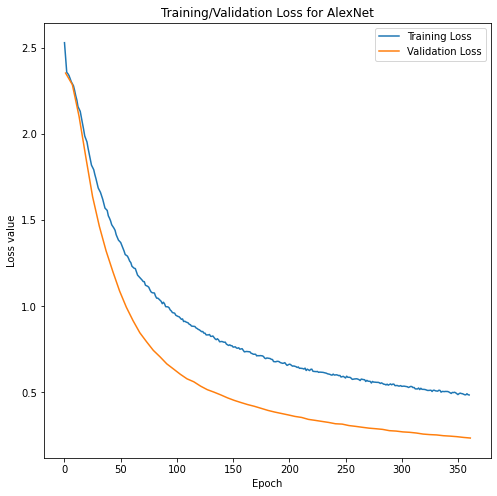

In [ ]:
#plot losses over epoch
ax = df.query("mode == 'train'")['loss'].plot()
df.query("mode == 'val'")['loss'].plot()
ax.legend(('Training Loss', 'Validation Loss'))
ax.set_title('Training/Validation Loss for AlexNet')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss value')

Text(0, 0.5, 'Accuracy value')

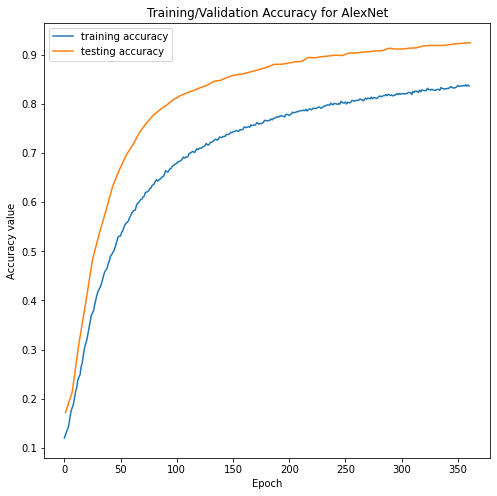

In [ ]:
ax  = df.query("mode == 'train'")['accuracy'].plot()
df.query("mode == 'val'")['accuracy'].plot()
ax.legend(('training accuracy', 'testing accuracy'))
ax.set_title('Training/Validation Accuracy for AlexNet')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy value')

In [ ]:
#saving logs on local machine
df.to_pickle('vgg_benchmark_17_nov_logs.pkl')

# Calculate accuracies seperately for old and novel tasks

In [31]:
#create old and novel test dataloader to calculate accuracy seperately
old_test_dataset = SubsetSC("testing", "old")
novel_data = ["follow"]
novel_test_dataset = SubsetSC("testing", "novel", ["follow"])
digits = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'] 
digits += novel_data

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

def collate_fn(batch):
        tensors, targets = [], []
        for waveform, label in batch:
                tensors += [torch.squeeze(waveform)]
                targets += [label_to_index(digits, label)]
                
        tensors = torch.unsqueeze(pad_sequence(tensors), 1)
        targets = torch.stack(targets)
        return tensors, targets

old_test_dataloader = DataLoader(old_test_dataset,batch_size=100, collate_fn=collate_fn, shuffle=True)
novel_test_dataloader = DataLoader(novel_test_dataset,batch_size=100, collate_fn=collate_fn, shuffle=True)

#model 
print("Initializing the neural network...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
model = models.VGGNet()

#in case of benchmark need to add extra node at last linear layer in vgg
in_features = model.linear.in_features
out_features = model.linear.out_features
out_features += len(novel_data)
model.linear = nn.Linear(in_features=in_features, out_features=out_features)
#load saved pre-trained benchmark
model.load_state_dict(copy.deepcopy(torch.load("results/Benchmark/checkpoint_vgg_benchmark.pth", map_location='cpu')), strict=False)
model.to(device)

#calculate accuracy for old tasks
validation_accuracy = []
for i, (inputs, labels) in enumerate(old_test_dataloader):
  inputs, labels = inputs.to(device), labels.to(device)
  logits = model(inputs)
  _, pred = logits.max(1)
  acc = (pred == labels).sum().item() / pred.size(0) 
  validation_accuracy.append(acc)
      
avg_old_task_accuracy = sum(validation_accuracy)/len(validation_accuracy)
print(f"Old class accuracy: {avg_old_task_accuracy}")

#calculate accuracy for old tasks
validation_accuracy = []
for i, (inputs, labels) in enumerate(novel_test_dataloader):
  inputs, labels = inputs.to(device), labels.to(device)
  logits = model(inputs)
  _, pred = logits.max(1)
  acc = (pred == labels).sum().item() / pred.size(0) 
  validation_accuracy.append(acc)
      
avg_novel_task_accuracy = sum(validation_accuracy)/len(validation_accuracy)
print(f"Novel class accuracy: {avg_novel_task_accuracy}")


Initializing the neural network...
Device: cuda
Old class accuracy: 0.8489795918367348
Novel class accuracy: 0.7130555555555556
